In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

In [2]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# 뉴럴 스타일 트랜스퍼

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/deep-learning-with-python/) 책의 8장 3절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다. 이 노트북의 설명은 케라스 버전 2.2.2에 맞추어져 있습니다. 케라스 최신 버전이 릴리스되면 노트북을 다시 테스트하기 때문에 설명과 코드의 결과가 조금 다를 수 있습니다.

----

딥드림 이외에 딥러닝을 사용하여 이미지를 변경하는 또 다른 주요 분야는 뉴럴 스타일 트랜스퍼입니다. 2015년 여름 리온 게티스 등이 소개했습니다. 뉴럴 스타일 트랜스퍼 알고리즘은 처음 소개된 이후에 많이 개선되었고 여러 변종들이 생겼습니다. 스마트폰의 사진 앱에도 쓰입니다. 이 절에서는 간단하게 원본 논문에 소개한 방식에 집중하겠습니다.

뉴럴 스타일 트랜스퍼는 타깃 이미지의 콘텐츠를 보존하면서 참조 이미지의 스타일을 타깃 이미지에 적용합니다:

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

여기에서 스타일은 질감, 색깔, 이미지에 있는 다양한 크기의 시각 요소를 의미합니다. 콘텐츠는 이미지에 있는 고수준의 대형 구조를 말합니다. 예를 들어 빈센트 반 고흐의 별이 빛나는 밤에서 파랑과 노랑색의 원을 그리는 듯한 붓질을 하나의 스타일로 생각할 수 있습니다. 튀빙겐 사진의 건물은 콘텐츠로 생각할 수 있습니다.

텍스처 생성과 밀접하게 연관된 스타일 트랜스퍼의 아이디어는 2015년 뉴럴 스타일 트랜스퍼가 개발되기 이전에 이미 이미지 처리 분야에서 오랜 역사를 가지고 있습니다. 딥러닝을 기반으로 한 스타일 트랜스퍼 구현은 고전적인 컴퓨터 비전 기법으로 만든 것과는 비견할 수 없는 결과를 제공합니다. 창조적인 컴퓨터 비전 애플리케이션 분야에 새로운 르네상스를 열었습니다.

스타일 트랜스퍼 구현 이면에 있는 핵심 개념은 모든 딥러닝 알고리즘의 핵심과 동일합니다. 목표를 표현한 손실 함수를 정의하고 이 손실을 최소화합니다. 여기서 원하는 것은 다음과 같습니다. 참조 이미지의 스타일을 적용하면서 원본 이미지의 콘텐츠를 보존하는 것입니다. 콘텐츠와 스타일을 수학적으로 정의할 수 있다면 최소화할 손실 함수는 다음과 같을 것입니다:

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```

여기에서 `distance`는 L2 노름 같은 노름 함수입니다. `content` 함수는 이미지의 콘텐츠 표현을 계산합니다. `style` 함수는 이미지의 스타일 표현을 계산합니다.

이 손실을 최소화면 `style(generated_image)`는 `style(reference_image)`와 가까워지고 `content(generated_image)`는 `content(original_image)`와 가까워집니다. 앞서 정의한 스타일 트랜스퍼의 목적을 달성할 수 있습니다.

게티스 등은 심층 합성곱 신경망을 사용해 `style`과 `content` 함수를 수학적으로 정의할 수 있다는 것을 보였습니다. 어떻게 하는 것인지 알아 보죠.

## 콘텐츠 손실

앞서 배웠듯이 네트워크에 있는 하위 층의 활성화는 이미지에 관한 국부적인 정보를 담고 있습니다. 반면 상위 층의 활성화일수록 점점 전역적이고 추상적인 정보를 담게 됩니다. 다른 방식으로 생각하면 컨브넷 층의 활성화는 이미지를 다른 크기의 콘텐츠로 분해한다고 볼 수 있습니다. 컨브넷 상위 층의 표현을 사용하면 전역적이고 추상적인 이미지 콘텐츠를 찾을 것입니다.

타깃 이미지와 생성된 이미지를 사전 훈련된 컨브넷에 주입하여 상위 층의 활성화를 계산합니다. 이 두 값 사이의 L2 노름이 콘텐츠 손실로 사용하기에 좋습니다. 상위 층에서 보았을 때 생성된 이미지와 원본 타깃 이미지를 비슷하게 만들 것입니다. 컨브넷의 상위 층이 보는 것이 입력 이미지의 콘텐츠라고 가정하면 이미지의 콘텐츠를 보존하는 방법으로 사용할 수 있습니다.

## 스타일 손실

콘텐츠 손실은 하나의 상위 층만 사용합니다. 게티스 등이 정의한 스타일 손실은 컨브넷의 여러 층을 사용합니다. 하나의 스타일이 아니라 참조 이미지에서 컨브넷이 추출한 모든 크기의 스타일을 잡아야 합니다.

게티스 등은 층의 활성화 출력의 그람 행렬을 스타일 손실로 사용했습니다. 그람 행렬은 층의 특성 맵들의 내적입니다. 내적은 층의 특성 사이에 있는 상관관계를 표현한다고 이해할 수 있습니다. 이런 특성의 상관관계는 특정 크기의 공간적인 패턴 통계를 잡아 냅니다. 경험적으로 봤을 때 이 층에서 찾은 텍스처에 대응됩니다.

스타일 참조 이미지와 생성된 이미지로 층의 활성화를 계산합니다. 스타일 손실은 그 안에 내재된 상관관계를 비슷하게 보존하는 것이 목적입니다. 결국 스타일 참조 이미지와 생성된 이미지에서 여러 크기의 텍스처가 비슷하게 보이도록 만듭니다.

## 요약

요약하면 사전 훈련된 컨브넷을 사용해 다음과 같은 손실을 정의할 수 있습니다:

* 콘텐츠를 보존하기 위해 타깃 콘텐츠 이미지와 생성된 이미지 사이에서 상위 층의 활성화를 비슷하게 유지합니다. 이 컨브넷은 타깃 이미지와 생성된 이미지에서 동일한 것을 보아야 합니다.
* 스타일을 보존하기 위해 저수준 층과 고수준 층에서 활성화 내에 상관관계를 비슷하게 유지합니다. 특성의 상관관계는 텍스처를 잡아냅니다. 생성된 이미지와 스타일 참조 이미지는 여러 크기의 텍스처를 공유할 것입니다.

이제 2015년 뉴럴 스타일 트랜스퍼 원본 알고리즘을 케라스로 구현해 보죠. 잠시 후 알게 되겠지만 이전 절에서 만든 딥드림 구현과 공통점이 많습니다.

## 케라스에서 뉴럴 스타일 트랜스퍼 구현하기

뉴럴 스타일 트랜스퍼는 사전 훈련된 컨브넷 중 어떤 것을 사용해서도 구현할 수 있습니다. 여기에서는 게티스 등이 사용한 VGG19 네트워크를 사용하겠습니다. VGG19는 5장에서 소개한 VGG16 네트워크의 변종으로 합성곱 층이 3개 더 추가되었습니다.

일반적인 과정은 다음과 같습니다:

1.	스타일 참조 이미지, 타깃 이미지, 생성된 이미지를 위해 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정합니다.
2.	세 이미지에서 계산한 층 활성화를 사용하여 앞서 설명한 손실 함수를 정의합니다. 이 손실을 최소화하여 스타일 트랜스퍼를 구현할 것입니다.
3.	손실 함수를 최소화할 경사 하강법 과정을 설정합니다.

스타일 참조 이미지와 타깃 이미지의 경로를 정의하는 것부터 시작하죠. 처리할 이미지는 크기가 비슷합니다(크기가 많이 다르면 스타일 트랜스퍼를 구현하는 것이 더 어렵습니다). 모두 높이가 400 픽셀이 되도록 크기를 변경하겠습니다.

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './datasets/portrait.png'
# 스타일 이미지 경로
style_reference_image_path = './datasets/popova.jpg'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

VGG19 컨브넷에 입출력할 이미지의 로드, 전처리, 사후 처리를 위해 유틸리티 함수를 정의합니다:

In [4]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

VGG19 네트워크를 설정해 보죠. 스타일 참조 이미지, 타깃 이미지 그리고 생성된 이미지가 담긴 플레이스홀더로 이루어진 배치를 입력으로 받습니다. 플레이스홀더는 심볼릭 텐서로 넘파이 배열로 밖에서 값을 제공해야 합니다. 스타일 참조 이미지와 타깃 이미지는 이미 준비된 데이터이므로 K.constant를 사용해 정의합니다. 반면 플레이스홀더에 담길 생성된 이미지는 계속 바뀝니다.

In [5]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

80142336/80134624 [==============================] - 6s 0us/step
모델 로드 완료.


콘텐츠 손실을 정의해 보죠. VGG19 컨브넷의 상위 층은 타깃 이미지와 생성된 이미지를 동일하게 바라봐야 합니다:

In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

다음은 스타일 손실입니다. 유틸리티 함수를 사용해 입력 행렬의 그람 행렬을 계산합니다. 이 행렬은 원본 특성 행렬의 상관관계를 기록한 행렬입니다.

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

두 손실에 하나를 더 추가합니다. 생성된 이미지의 픽셀을 사용해 계산하는 총 변위 손실입니다. 이는 생성된 이미지가 공간적인 연속성을 가지도록 도와주며 픽셀의 격자 무늬가 과도하게 나타나는 것을 막아줍니다. 이를 일종의 규제 항으로 해석할 수 있습니다.

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

최소화할 손실은 이 세 손실의 가중치 평균입니다. 콘텐츠 손실은 `block5_conv2` 층 하나만 사용해서 계산합니다. 스타일 손실을 계산하기 위해서는 하위 층과 상위 층에 걸쳐 여러 층을 사용합니다. 그리고 마지막에 총 변위 손실을 추가합니다.

사용하는 스타일 참조 이미지와 콘텐츠 이미지에 따라 `content_weight` 계수(전체 손실에 기여하는 콘텐츠 손실의 정도)를 조정하는 것이 좋습니다. `content_weight`가 높으면 생성된 이미지에 타깃 콘텐츠가 더 많이 나타나게 됩니다.

In [9]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

마지막으로 경사 하강법 단계를 설정합니다. 게티스의 원래 논문에서 L-BFGS 알고리즘을 사용하여 최적화를 수행했으므로 여기에서도 이를 사용하겠습니다. 8.2절의 딥드림 예제와 가장 크게 차이 나는 부분입니다. L-BFGS 알고리즘은 싸이파이에 구현되어 있는데 두 가지 제약 사항이 있습니다.

* 손실 함수의 값과 그래디언트 값을 별개의 함수로 전달해야 합니다.
* 이 함수는 3D 이미지 배열이 아니라 1차원 벡터만 처리할 수 있습니다.

손실 함수의 값과 그래디언트 값을 따로 계산하는 것은 비효율적입니다. 두 계산 사이에 중복되는 계산이 많기 때문입니다. 한꺼번에 계산하는 것보다 거의 두 배 가량 느립니다. 이를 피하기 위해 손실과 그래디언트 값을 동시에 계산하는 `Evaluator`란 이름의 파이썬 클래스를 만들겠습니다. 처음 호출할 때 손실 값을 반환하면서 다음 호출을 위해 그래디언트를 캐싱합니다.

In [10]:
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

마지막으로 싸이파이 L-BFGS 알고리즘을 사용하여 경사 하강법 단계를 수행합니다. 알고리즘 반복마다 생성된 이미지를 저장합니다(여기에서는 한 번 반복이 경사 하강법 단계 20번입니다):

In [11]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 8101800000.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 17s
반복 횟수: 1
현재 손실 값: 3130190600.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 2s
반복 횟수: 2
현재 손실 값: 2035212900.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 2s
반복 횟수: 3
현재 손실 값: 1528455600.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 2s
반복 횟수: 4
현재 손실 값: 1257272400.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 2s
반복 횟수: 5
현재 손실 값: 1084889200.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 2s
반복 횟수: 6
현재 손실 값: 975324700.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 2s
반복 횟수: 7
현재 손실 값: 883559040.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 2s
반복 횟수: 8
현재 손실 값: 821572100.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 2s
반복 횟수: 9
현재 손실 값: 771555840.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 2s
반복 횟수: 10
현재 손실 값: 729725950.0
저장 이미지:  sty

다음이 만들어진 이미지입니다:

In [12]:
from matplotlib import pyplot as plt

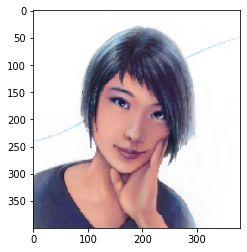

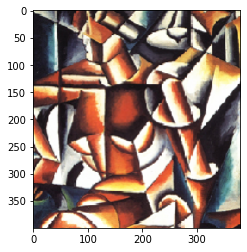

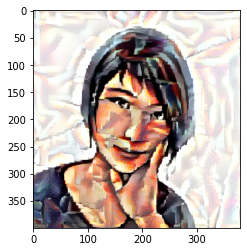

In [13]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()

이 기법은 이미지의 텍스처를 바꾸거나 텍스처를 전이한 것임을 기억하세요. 스타일 이미지의 텍스처가 두드러지고 비슷한 패턴이 많을 때 잘 작동합니다. 또 콘텐츠 타깃을 알아 보기 위해 수준 높은 이해가 필요하지 않을 때 잘 작동합니다. 일반적으로 인물 사진의 스타일을 다른 인물 사진으로 옮기는 것같이 아주 추상적인 기교는 만들지 못합니다. 이 알고리즘은 AI 보다는 고전적인 시그널 처리에 가깝기 때문에 마술 같은 결과를 기대하지 마세요!

스타일 트랜스퍼 알고리즘은 느리지만 간단한 변환을 수행하기 때문에 작고 빠른 컨브넷을 사용해 학습할 수 있습니다. 물론 적절한 양의 훈련 데이터가 있어야 합니다. 먼저 고정된 스타일 참조 이미지에 대해서 여기에서 소개한 방법으로 입력-출력 훈련 샘플을 많이 생성합니다. 그다음 이 스타일 변환을 학습하는 간단한 컨브넷을 훈련하면 스타일 트랜스퍼를 빠르게 수행할 수 있습니다. 이런 모델을 만들면 어떤 이지미가 주어졌을 때 순식간에 스타일을 바꿀 수 있습니다. 그냥 이 작은 컨브넷을 통과시키면 됩니다.

## 정리

* 스타일 트랜스퍼는 참조 이미지의 스타일을 적용하면서 타깃 이미지의 콘텐츠를 보존하여 새로운 이미지를 만드는 방법입니다.
* 콘텐츠는 컨브넷 상위 층의 활성화에서 얻을 수 있습니다.
* 스타일은 여러 컨브넷 층의 활성화 안에 내재된 상관관계에서 얻을 수 있습니다.
* 딥러닝에서는 사전 훈련된 컨브넷으로 손실을 정의하고 이 손실을 최적화하는 과정으로 스타일 트랜스퍼를 구성할 수 있습니다.
이런 기본 아이디어에서 출발하여 다양한 변종과 개선이 가능합니다.